# Ingesting data and read it back

In [210]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("NFLPlaystoPostgres") \
    .getOrCreate()

csv_file_path = "E:/Fall 24/Systems and Tools/HW/HW4/plays.csv"
plays_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)
url = "jdbc:postgresql://localhost:5432/postgres"  
properties = {
    "user": "postgres",
    "password": "Sakhaleyash@1",
    "driver": "org.postgresql.Driver"
}

plays_df.write.jdbc(url=url, table="Plays", mode="overwrite", properties=properties)
df_from_postgres = spark.read.jdbc(url=url, table="Plays", properties=properties)
df_from_postgres.show(5, vertical=True)

-RECORD 0--------------------------------------
 gameId                 | 2017091004           
 playId                 | 37                   
 quarter                | 1                    
 GameClock              | 2024-10-03 15:00:00  
 down                   | 0                    
 yardsToGo              | 0                    
 possessionTeam         | DET                  
 yardlineSide           | DET                  
 yardlineNumber         | 35                   
 offenseFormation       | NA                   
 personnel.offense      | NA                   
 defendersInTheBox      | NA                   
 numberOfPassRushers    | NA                   
 personnel.defense      | NA                   
 HomeScoreBeforePlay    | 0                    
 VisitorScoreBeforePlay | 0                    
 HomeScoreAfterPlay     | 0                    
 VisitorScoreAfterPlay  | 0                    
 isPenalty              | false                
 isSTPlay               | true          

# Cleaning the data and casting

In [173]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, lit, when, regexp_replace, col, count
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

spark = SparkSession.builder.appName("NFLPlaystoPostgres").getOrCreate()

plays_df = spark.read.csv("E:/Fall 24/Systems and Tools/HW/HW4/plays.csv", header=True, inferSchema=True)
plays_df = plays_df.withColumnRenamed("personnel.offense", "renamed_personnel_offense") \
                   .withColumnRenamed("personnel.defense", "renamed_personnel_defense")

casted_types_df = plays_df.withColumn("GameClock", plays_df["GameClock"].cast("float"))
df_with_casted_kick_return_yardage = plays_df.withColumn("KickReturnYardage", col("KickReturnYardage").cast("int"))
casted_types_df.printSchema()
casted_types_df.show(5, vertical=True)

root
 |-- gameId: integer (nullable = true)
 |-- playId: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- GameClock: float (nullable = true)
 |-- down: integer (nullable = true)
 |-- yardsToGo: integer (nullable = true)
 |-- possessionTeam: string (nullable = true)
 |-- yardlineSide: string (nullable = true)
 |-- yardlineNumber: string (nullable = true)
 |-- offenseFormation: string (nullable = true)
 |-- renamed_personnel_offense: string (nullable = true)
 |-- defendersInTheBox: string (nullable = true)
 |-- numberOfPassRushers: string (nullable = true)
 |-- renamed_personnel_defense: string (nullable = true)
 |-- HomeScoreBeforePlay: integer (nullable = true)
 |-- VisitorScoreBeforePlay: integer (nullable = true)
 |-- HomeScoreAfterPlay: integer (nullable = true)
 |-- VisitorScoreAfterPlay: integer (nullable = true)
 |-- isPenalty: boolean (nullable = true)
 |-- isSTPlay: boolean (nullable = true)
 |-- SpecialTeamsPlayType: string (nullable = true)
 |-- KickRetu

# Using imputation in the column "KickReturnYardage" to fill missing values 

In [175]:
from pyspark.sql.functions import col, regexp_replace
df_cleaned = plays_df.withColumn("KickReturnYardage", regexp_replace(col("KickReturnYardage"), "[^0-9]", "").cast("int"))
columns_to_be_imputed = ["KickReturnYardage"]
df_with_filled_na = df_cleaned.fillna(-200, subset=columns_to_be_imputed)

imputer = Imputer(
    inputCols=columns_to_be_imputed,
    outputCols=["{}_imputed".format(c) for c in columns_to_be_imputed]
).setStrategy("median").setMissingValue(-200)

df_imputed = imputer.fit(df_with_filled_na).transform(df_with_filled_na)
df_imputed_enhanced = df_imputed.drop(columns_to_be_imputed[0])
df_fully_imputed = df_imputed_enhanced.withColumnRenamed(f"{columns_to_be_imputed[0]}_imputed", columns_to_be_imputed[0])

total_rows = df_fully_imputed.count()
threshold = 0.5 * total_rows
columns_to_drop = []
for col_name in df_fully_imputed.columns:
    null_count = df_fully_imputed.filter(col(col_name).isNull()).count()
    if null_count > threshold:
        columns_to_drop.append(col_name)


df_cleaned_columns = df_fully_imputed.drop(*columns_to_drop)

row_threshold = int(0.5 * len(df_cleaned_columns.columns))
df_cleaned_rows = df_cleaned_columns.dropna(thresh=row_threshold)

df_cleaned_rows.printSchema()
df_cleaned_rows.show(4, vertical=True)


root
 |-- gameId: integer (nullable = true)
 |-- playId: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- GameClock: timestamp (nullable = true)
 |-- down: integer (nullable = true)
 |-- yardsToGo: integer (nullable = true)
 |-- possessionTeam: string (nullable = true)
 |-- yardlineSide: string (nullable = true)
 |-- yardlineNumber: string (nullable = true)
 |-- offenseFormation: string (nullable = true)
 |-- renamed_personnel_offense: string (nullable = true)
 |-- defendersInTheBox: string (nullable = true)
 |-- numberOfPassRushers: string (nullable = true)
 |-- renamed_personnel_defense: string (nullable = true)
 |-- HomeScoreBeforePlay: integer (nullable = true)
 |-- VisitorScoreBeforePlay: integer (nullable = true)
 |-- HomeScoreAfterPlay: integer (nullable = true)
 |-- VisitorScoreAfterPlay: integer (nullable = true)
 |-- isPenalty: boolean (nullable = true)
 |-- isSTPlay: boolean (nullable = true)
 |-- SpecialTeamsPlayType: string (nullable = true)
 |-- Pass

# Feature Engineering

In [212]:
df_fully_imputed.printSchema() #Variable Types
df_fully_imputed.describe().show(2 , vertical=True) # Summary Statistics
df_fully_imputed.summary().show(truncate=False, vertical=True) 

#Identifying numeric columns 
numeric_features = [feature[0] for feature in df_fully_imputed.dtypes if feature[1] in ('int','double')]
numeric_features


root
 |-- gameId: integer (nullable = true)
 |-- playId: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- GameClock: timestamp (nullable = true)
 |-- down: integer (nullable = true)
 |-- yardsToGo: integer (nullable = true)
 |-- possessionTeam: string (nullable = true)
 |-- yardlineSide: string (nullable = true)
 |-- yardlineNumber: string (nullable = true)
 |-- offenseFormation: string (nullable = true)
 |-- renamed_personnel_offense: string (nullable = true)
 |-- defendersInTheBox: string (nullable = true)
 |-- numberOfPassRushers: string (nullable = true)
 |-- renamed_personnel_defense: string (nullable = true)
 |-- HomeScoreBeforePlay: integer (nullable = true)
 |-- VisitorScoreBeforePlay: integer (nullable = true)
 |-- HomeScoreAfterPlay: integer (nullable = true)
 |-- VisitorScoreAfterPlay: integer (nullable = true)
 |-- isPenalty: integer (nullable = true)
 |-- isSTPlay: integer (nullable = true)
 |-- SpecialTeamsPlayType: string (nullable = true)
 |-- Pass

['gameId',
 'playId',
 'quarter',
 'down',
 'yardsToGo',
 'HomeScoreBeforePlay',
 'VisitorScoreBeforePlay',
 'HomeScoreAfterPlay',
 'VisitorScoreAfterPlay',
 'isPenalty',
 'isSTPlay',
 'PlayResult',
 'KickReturnYardage']

# Five number summary and Boxplot

Five-number summary for gameId: [2017090700.0, 2017091708.0, 2017092413.0, 2017100801.0, 2017101600.0]
Five-number summary for playId: [35.0, 1059.0, 2054.0, 2965.0, 5531.0]
Five-number summary for quarter: [1.0, 2.0, 2.0, 3.0, 5.0]
Five-number summary for down: [0.0, 1.0, 2.0, 2.0, 4.0]
Five-number summary for yardsToGo: [0.0, 5.0, 10.0, 10.0, 40.0]
Five-number summary for HomeScoreBeforePlay: [0.0, 3.0, 10.0, 16.0, 57.0]
Five-number summary for VisitorScoreBeforePlay: [0.0, 0.0, 7.0, 15.0, 42.0]
Five-number summary for HomeScoreAfterPlay: [0.0, 3.0, 10.0, 17.0, 57.0]
Five-number summary for VisitorScoreAfterPlay: [0.0, 0.0, 7.0, 16.0, 42.0]
Five-number summary for isPenalty: [0.0, 0.0, 0.0, 0.0, 1.0]
Five-number summary for isSTPlay: [0.0, 0.0, 0.0, 0.0, 1.0]
Five-number summary for PlayResult: [-86.0, 0.0, 4.0, 10.0, 90.0]
Five-number summary for KickReturnYardage: [0.0, 13.0, 13.0, 13.0, 999.0]


C:\Users\yashs\AppData\Local\Temp\ipykernel_69244\2388922201.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=numeric_columns)


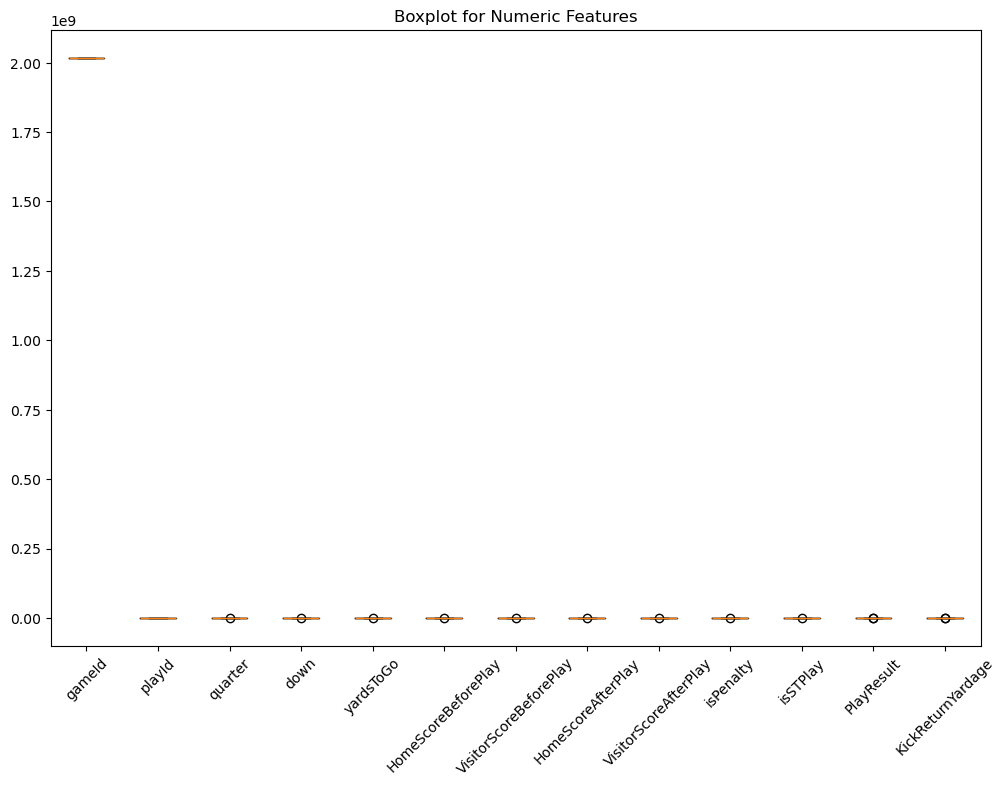

In [214]:
#Five number summary

from pyspark.sql.functions import col
import matplotlib.pyplot as plt

numeric_columns = [col_name for col_name, dtype in df_fully_imputed.dtypes if dtype in ('int', 'double')]
five_number_summary = {}
for col_name in numeric_columns:
    summary = df_fully_imputed.approxQuantile(col_name, [0.0, 0.25, 0.5, 0.75, 1.0], 0.05)
    five_number_summary[col_name] = summary

for col_name, summary in five_number_summary.items():
    print(f"Five-number summary for {col_name}: {summary}")

#Boxplot

boxplot_data = [five_number_summary[col] for col in numeric_columns]

plt.figure(figsize=(12, 8))
plt.boxplot(boxplot_data, labels=numeric_columns)
plt.title("Boxplot for Numeric Features")
plt.xticks(rotation=45)
plt.show()


# Outliers 

In [216]:
#Identifying outliers

subset_columns = numeric_columns[:5]  # Select the first 5 numeric columns as a subset

outliers_info = {}

# Calculate IQR and identify outliers for each column in the subset
for col_name in subset_columns:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    quantiles = df_fully_imputed.approxQuantile(col_name, [0.25, 0.75], 0.05)
    Q1, Q3 = quantiles[0], quantiles[1]
    
    IQR = Q3 - Q1
    
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_df = df_fully_imputed.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound))

    outliers_info[col_name] = {
        "Q1": Q1,
        "Q3": Q3,
        "IQR": IQR,
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound,
        "Number of Outliers": outliers_df.count()
    }
    
    print(f"Outliers info for {col_name}:")
    print(outliers_info[col_name])
    outliers_df.show(2, vertical=True)

Outliers info for gameId:
{'Q1': 2017091708.0, 'Q3': 2017100801.0, 'IQR': 9093.0, 'Lower Bound': 2017078068.5, 'Upper Bound': 2017114440.5, 'Number of Outliers': 0}
(0 rows)

Outliers info for playId:
{'Q1': 1059.0, 'Q3': 2965.0, 'IQR': 1906.0, 'Lower Bound': -1800.0, 'Upper Bound': 5824.0, 'Number of Outliers': 0}
(0 rows)

Outliers info for quarter:
{'Q1': 2.0, 'Q3': 3.0, 'IQR': 1.0, 'Lower Bound': 0.5, 'Upper Bound': 4.5, 'Number of Outliers': 116}
-RECORD 0-----------------------------------------
 gameId                    | 2017091702           
 playId                    | 4307                 
 quarter                   | 5                    
 GameClock                 | 2024-10-03 10:00:00  
 down                      | 0                    
 yardsToGo                 | 0                    
 possessionTeam            | ARI                  
 yardlineSide              | ARI                  
 yardlineNumber            | 35                   
 offenseFormation          | NA   

# For Binary Varaibles casting

In [183]:
from pyspark.sql.functions import col

binary_columns = ["isPenalty", "isSTPlay"] 

for col_name in binary_columns:
    df_fully_imputed = df_fully_imputed.withColumn(col_name, col(col_name).cast("integer"))

df_fully_imputed.select(binary_columns).show(5)

+---------+--------+
|isPenalty|isSTPlay|
+---------+--------+
|        0|       1|
|        0|       0|
|        0|       0|
|        0|       0|
|        0|       0|
+---------+--------+
only showing top 5 rows



# Visualizing Variable distribution and Finding corelation 

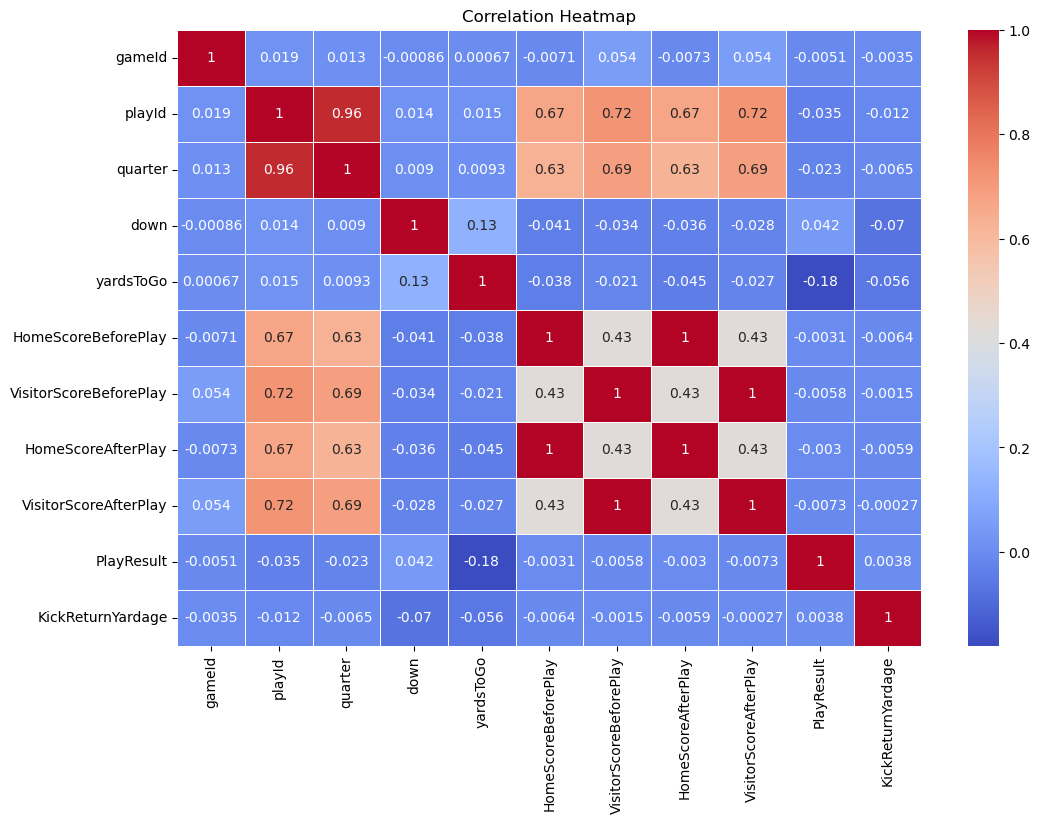

In [185]:
#Finding Corelation and Visulaizing the variable distribution
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import Row
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
df_vector = assembler.transform(df_fully_imputed).select("features")

correlation_matrix = Correlation.corr(df_vector, "features").head()[0]
correlation_values = correlation_matrix.toArray()

df_corr = pd.DataFrame(correlation_values, index=numeric_columns, columns=numeric_columns)

plt.figure(figsize=(12, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Encoding Nominal And Ordinal Variables

In [226]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

nominal_columns = ["HomeScoreBeforePlay", "VisitorScoreBeforePlay"]

stage_1 = StringIndexer(inputCol='HomeScoreBeforePlay', outputCol='HomeScoreBeforePlay_index')
stage_2 = StringIndexer(inputCol='VisitorScoreBeforePlay', outputCol='VisitorScoreBeforePlay_index')

stage_3 = OneHotEncoder(inputCols=['HomeScoreBeforePlay_index', 'VisitorScoreBeforePlay_index'], 
                        outputCols=['HomeScoreBeforePlay_encoded', 'VisitorScoreBeforePlay_encoded'])

pipeline = Pipeline(stages=[stage_1, stage_2, stage_3])

pipeline_model = pipeline.fit(df_fully_imputed)
df_encoded = pipeline_model.transform(df_fully_imputed)

df_encoded.select('HomeScoreBeforePlay', 'HomeScoreBeforePlay_index', 'HomeScoreBeforePlay_encoded',
                  'VisitorScoreBeforePlay', 'VisitorScoreBeforePlay_index', 'VisitorScoreBeforePlay_encoded'
                  ).show(5, truncate=False)


+-------------------+-------------------------+---------------------------+----------------------+----------------------------+------------------------------+
|HomeScoreBeforePlay|HomeScoreBeforePlay_index|HomeScoreBeforePlay_encoded|VisitorScoreBeforePlay|VisitorScoreBeforePlay_index|VisitorScoreBeforePlay_encoded|
+-------------------+-------------------------+---------------------------+----------------------+----------------------------+------------------------------+
|0                  |0.0                      |(47,[0],[1.0])             |0                     |0.0                         |(38,[0],[1.0])                |
|0                  |0.0                      |(47,[0],[1.0])             |0                     |0.0                         |(38,[0],[1.0])                |
|0                  |0.0                      |(47,[0],[1.0])             |0                     |0.0                         |(38,[0],[1.0])                |
|0                  |0.0                      

# Combining Features into Single Vector

In [232]:
numeric_columns = ["yardsToGo", "down"]  
nominal_onehot_columns = ['HomeScoreBeforePlay_encoded', 'VisitorScoreBeforePlay_encoded']

ordinal_indexed_columns = []

input_features = numeric_columns + ordinal_indexed_columns + nominal_onehot_columns
assembler = VectorAssembler(inputCols=input_features, outputCol="features")

df_with_features = assembler.transform(df_encoded)

df_with_features.select("features").show(5, truncate=False)


+----------------------------------+
|features                          |
+----------------------------------+
|(87,[2,49],[1.0,1.0])             |
|(87,[0,1,2,49],[10.0,1.0,1.0,1.0])|
|(87,[0,1,2,49],[6.0,2.0,1.0,1.0]) |
|(87,[0,1,2,49],[4.0,3.0,1.0,1.0]) |
|(87,[0,1,2,49],[10.0,1.0,1.0,1.0])|
+----------------------------------+
only showing top 5 rows



# Data Scaling

In [234]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="standardized_features", withMean=True, withStd=True)

scaler_model = scaler.fit(df_with_features)
df_standardized = scaler_model.transform(df_with_features)

df_standardized.select("standardized_features").show(5, truncate=True)

+---------------------+
|standardized_features|
+---------------------+
| [-1.6704612073171...|
| [0.45450235155930...|
| [-0.3954830719912...|
| [-0.8204757837665...|
| [0.45450235155930...|
+---------------------+
only showing top 5 rows



In [236]:
from pyspark.ml.feature import Normalizer

normalizer = Normalizer(inputCol="standardized_features", outputCol="normalized_features", p=2.0)

df_normalized = normalizer.transform(df_standardized)
df_normalized.select("normalized_features").show(5, truncate=True)


+--------------------+
| normalized_features|
+--------------------+
|[-0.4550438333928...|
|[0.15285478673030...|
|[-0.1372612497546...|
|[-0.2608920166073...|
|[0.15285478673030...|
+--------------------+
only showing top 5 rows

